
# Customer life time value:  Predicting Total Insurance Claim amount for an Auto Insurance company
## Introduction
This project analyzes the Customer Lifetime Value Dataset to predict the Total Insurance Claim Amount based on demographic, vehicle-related, and insurance-specific factors. The project involves:

Exploratory Data Analysis (EDA) to understand the dataset and identify trends.
Building a regression model to predict the Total Insurance Claim Amount effectively.
Conducting error analysis to evaluate the model's performance and identify areas for improvement.


In [194]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import xgboost as xgb
from sklearn.metrics import mean_squared_error
import os

# Data analysis

### Load Dataset


In [195]:
data_path = "data/car_insurance.csv"  # Path to your dataset
data = pd.read_csv(data_path)

### Data Overview


In [196]:
print("Dataset Shape:", data.shape)
print("First 5 Rows:")
print(data.head())

Dataset Shape: (9806, 22)
First 5 Rows:
   CustomerID  Customer.Lifetime.Value Coverage             Education  \
0        5917              7824.372789    Basic              Bachelor   
1        2057              8005.964669    Basic               College   
2        4119              8646.504109    Basic  High School or Below   
3        1801              9294.088719    Basic               College   
4        9618              5595.971365    Basic              Bachelor   

  EmploymentStatus Gender Income Location.Geo Location.Code Marital.Status  \
0       Unemployed      F      0    17.7,77.7         Urban        Married   
1         Employed      M  63357    28.8,76.6      Suburban        Married   
2         Employed      F  64125    21.6,88.4         Urban        Married   
3         Employed      M  67544      19,72.5      Suburban        Married   
4          Retired      F  19651    19.1,74.7      Suburban        Married   

   Monthly.Premium.Auto  Months.Since.Last.Claim  \


### Handling Missing Data


In [197]:
missing_values = data.isnull().sum()
print("\nMissing Values:")
print(missing_values[missing_values > 0])


Missing Values:
Coverage                     925
Education                    129
EmploymentStatus             118
Gender                       129
Location.Code                119
Marital.Status               129
Monthly.Premium.Auto         794
Number.of.Open.Complaints    818
Number.of.Policies           121
Policy.Type                  891
Policy                       121
Renew.Offer.Type             128
Sales.Channel                128
Vehicle.Class                126
Vehicle.Size                 126
dtype: int64


# Visualizations

### Visualization 1: Claim Amount by Location

This box plot shows the distribution of Total Claim Amount across different Locations (Urban, Suburban, Rural)

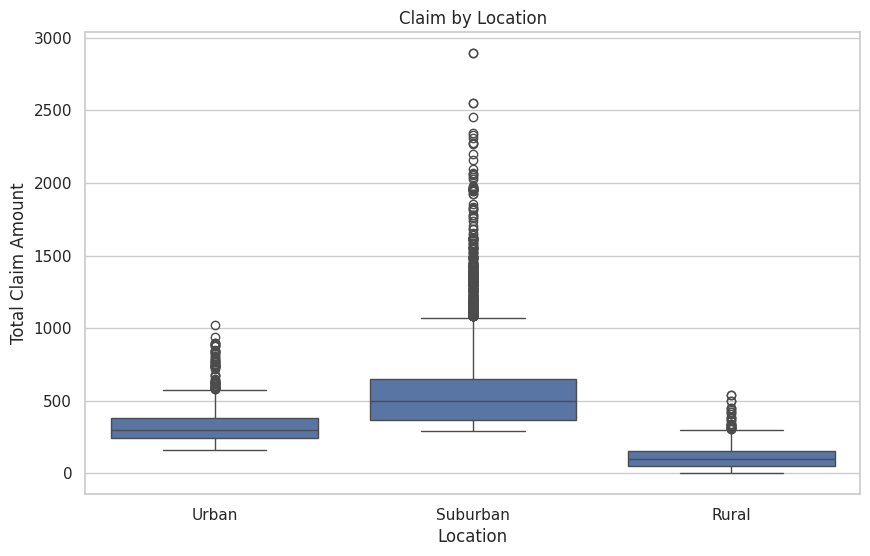

In [198]:

plt.figure(figsize=(10, 6))
sns.boxplot(x='Location.Code', y='Total.Claim.Amount', data=data)
plt.title("Claim by Location")
plt.xlabel("Location")
plt.ylabel("Total Claim Amount")
plt.show()


The plot shows that suburban areas exhibit the highest median claim amounts, suggesting that claims in suburban areas are typically higher than in urban or rural locations.
Urban and Rural areas show lower median claim amounts, with Urban slightly higher than Rural.

### Visualization 2: Claim Amount by Vehicle Class

This box plot explores the relationship between Vehicle Class (x-axis) and the Insurance Claim Amounts (y-axis)

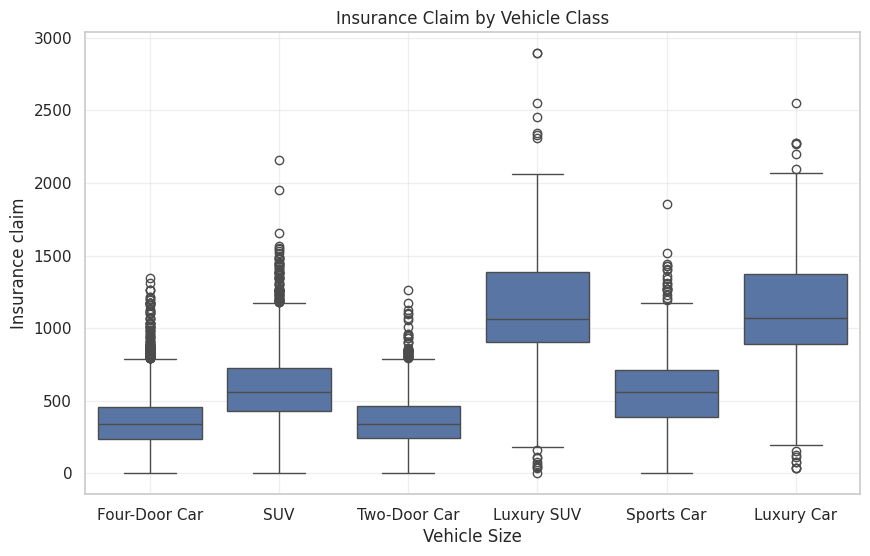

In [199]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Vehicle.Class', y='Total.Claim.Amount', data=data)
plt.title("Insurance Claim by Vehicle Class")
plt.xlabel("Vehicle Size")
plt.ylabel("Insurance claim")
plt.grid(alpha=0.3)
plt.show()


 The boxplot shows that claim amounts vary by vehicle types: Four-Door Cars, Two-Door Cars, and SUVs generally have lower median claim amounts compared to Luxury SUVs, Sports Cars, and Luxury Cars.
Luxury SUVs and Luxury Cars tend to have higher median claim amounts, suggesting that these vehicles may be associated with higher insurance claims, possibly due to their value or repair costs.

### Visualization 3: Total Claim Amount by Marital Status

 This box plot explores the relationship between Marital Statues (x-axis) and the Insurance Claim Amounts (y-axis)

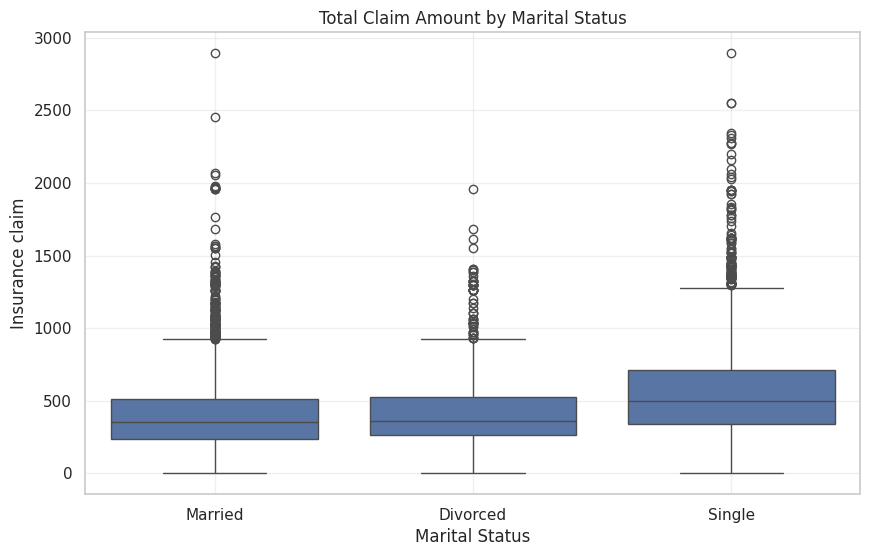

In [200]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='Marital.Status', y='Total.Claim.Amount', data=data)
plt.title("Total Claim Amount by Marital Status")
plt.xlabel("Marital Status")
plt.ylabel("Insurance claim")
plt.grid(alpha=0.3)
plt.show()


It shows that the median claim amount is slightly higher for singles compared to married and divorced individuals, indicating that singles tend to have higher typical claims. Additionally, singles exhibit greater variability in claim amounts, with a wider range of outliers compared to the other groups.

### Visualization 4: Distribution of Total Claim Amount

This histogram reveals the overall distribution of Total Insurance Claim amounts in the dataset. The plot helps identify the range, central tendency, and any outliers in the target variable.

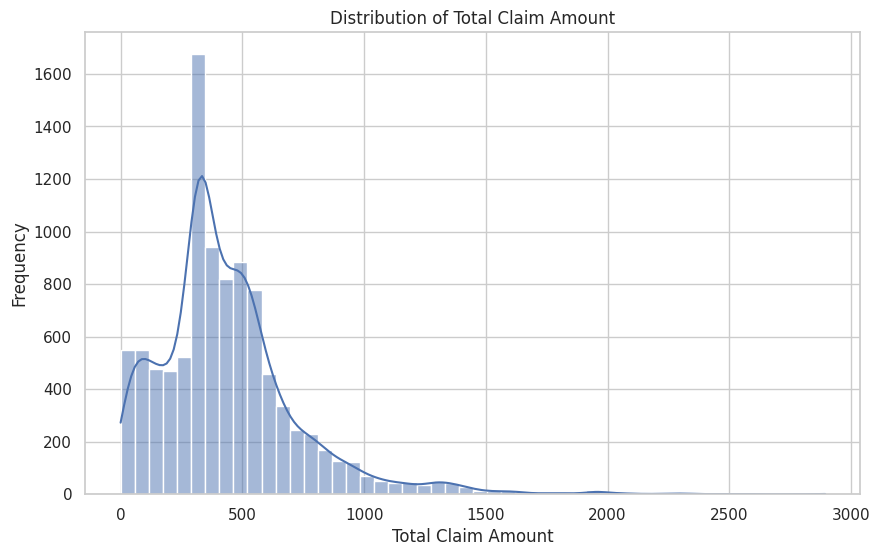

In [201]:
plt.figure(figsize=(10, 6))
sns.histplot(data['Total.Claim.Amount'], bins=50, kde=True)
plt.title("Distribution of Total Claim Amount")
plt.xlabel("Total Claim Amount")
plt.ylabel("Frequency")
plt.show()

The distribution of insurance claim amounts is right-skewed, with most claims concentrated between 0 and 1000, peaking around the 400-500 range. Higher claim amounts are much less frequent, as indicated by the long tail extending toward 3000. This suggests smaller claims are more common, while large claims are rare outliers.

### Visualization 5: Monthly Premium vs Claim Amount

This scatter plot examines the relationship between the Monthly Premium Price and the Total Claim Amount.


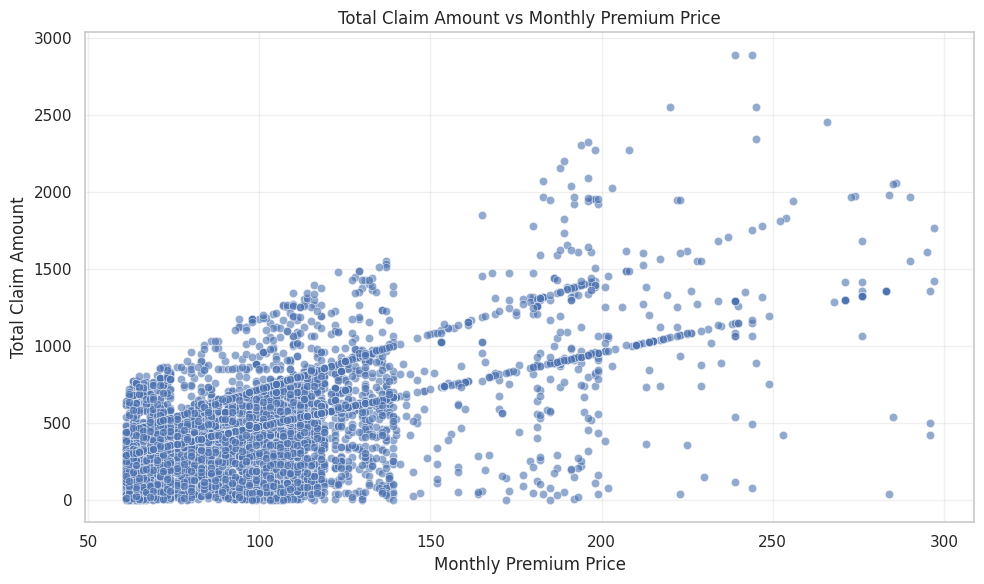

In [202]:
# Check the unique values of the 'EducationField' column before encoding
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Monthly.Premium.Auto', y='Total.Claim.Amount', data=data, alpha=0.6)

# Add title and labels
plt.title("Total Claim Amount vs Monthly Premium Price")
plt.xlabel("Monthly Premium Price")
plt.ylabel("Total Claim Amount")

# Show the plot
plt.tight_layout()
plt.grid(alpha=0.3)
plt.show()


The scatterplot shows a positive relationship, as higher values of Monthly Premium Auto are generally associated with higher Total Claim Amounts. This indicates that customers paying higher premiums may also tend to file higher total claims.

# Part 3: Basic Model Pipeline

## Identify Numerical and Categorical Columns

In [203]:
numerical_columns = data.select_dtypes(include=['float64', 'int64']).columns.tolist()
categorical_columns = data.select_dtypes(include=['object', 'category']).columns.tolist()
print("\nNumerical Columns:", numerical_columns)
print("\nCategorical Columns:", categorical_columns)



Numerical Columns: ['CustomerID', 'Customer.Lifetime.Value', 'Monthly.Premium.Auto', 'Months.Since.Last.Claim', 'Months.Since.Policy.Inception', 'Number.of.Open.Complaints', 'Number.of.Policies', 'Total.Claim.Amount', 'Vehicle.Size']

Categorical Columns: ['Coverage', 'Education', 'EmploymentStatus', 'Gender', 'Income', 'Location.Geo', 'Location.Code', 'Marital.Status', 'Policy.Type', 'Policy', 'Renew.Offer.Type', 'Sales.Channel', 'Vehicle.Class']


## Categorical Encoding

One hot encode categorical features for the XGBoost model

In [204]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

# Categorical Encoding
print("\nEncoding Categorical Columns:")
encoded_columns = {}

# Binary Columns - Label Encoding
binary_columns = ['Gender', 'Location.Code', 'Marital.Status']
le = LabelEncoder()
for col in binary_columns:
    print(f"Label encoding {col}")
    data[col] = le.fit_transform(data[col].astype(str))
    encoded_columns[col] = 'Label Encoding'

# Nominal Columns - One-Hot Encoding
nominal_columns = ['Coverage', 'Education', 'EmploymentStatus', 'Policy.Type',
                   'Policy', 'Renew.Offer.Type', 'Sales.Channel', 'Vehicle.Class']
for col in nominal_columns:
    print(f"One-hot encoding {col}")
    one_hot = pd.get_dummies(data[col], prefix=col)
    data = pd.concat([data, one_hot], axis=1)
    data.drop(columns=[col], inplace=True)
    encoded_columns[col] = 'One-Hot Encoding'

# Encoding Summary
print("\nEncoding Summary:")
for col, encoding in encoded_columns.items():
    print(f"{col}: {encoding}")

# Data after encoding
print("\nEncoded Data Preview:")
print(data.head())



Encoding Categorical Columns:
Label encoding Gender
Label encoding Location.Code
Label encoding Marital.Status
One-hot encoding Coverage
One-hot encoding Education
One-hot encoding EmploymentStatus
One-hot encoding Policy.Type
One-hot encoding Policy
One-hot encoding Renew.Offer.Type
One-hot encoding Sales.Channel
One-hot encoding Vehicle.Class

Encoding Summary:
Gender: Label Encoding
Location.Code: Label Encoding
Marital.Status: Label Encoding
Coverage: One-Hot Encoding
Education: One-Hot Encoding
EmploymentStatus: One-Hot Encoding
Policy.Type: One-Hot Encoding
Policy: One-Hot Encoding
Renew.Offer.Type: One-Hot Encoding
Sales.Channel: One-Hot Encoding
Vehicle.Class: One-Hot Encoding

Encoded Data Preview:
   CustomerID  Customer.Lifetime.Value  Gender Income Location.Geo  \
0        5917              7824.372789       0      0    17.7,77.7   
1        2057              8005.964669       1  63357    28.8,76.6   
2        4119              8646.504109       0  64125    21.6,88.4   
3 

### Encoding summary

In [205]:
print("\nEncoding Summary:")
for col, method in encoded_columns.items():
    print(f"{col}: {method}")


Encoding Summary:
Gender: Label Encoding
Location.Code: Label Encoding
Marital.Status: Label Encoding
Coverage: One-Hot Encoding
Education: One-Hot Encoding
EmploymentStatus: One-Hot Encoding
Policy.Type: One-Hot Encoding
Policy: One-Hot Encoding
Renew.Offer.Type: One-Hot Encoding
Sales.Channel: One-Hot Encoding
Vehicle.Class: One-Hot Encoding


## Prepare Features and Target for Modeling

#### First, we will drop irrelevant columns.

In [206]:
# we will also drop columns which are not important
columns_to_drop = ['CustomerID']
data = data.drop(columns=columns_to_drop, axis=1)

#### We will also drop the Total Claim Amount column as it is our target variable

In [207]:
X = data.drop(columns=['Total.Claim.Amount'])

y = data['Total.Claim.Amount']

#### Ensure all categorical columns are properly encoded for XGBoost

In [208]:
for col in X.select_dtypes(include=['object']).columns:
    print(f"Encoding column {col}")
    X[col] = LabelEncoder().fit_transform(X[col].astype(str))


Encoding column Income
Encoding column Location.Geo


#### Train-Test Split

Split data into 80% train and a 20% test set

In [209]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Train set size: ",len(X_train))
print("Test set size: ",len(X_test))

Train set size:  7844
Test set size:  1962


#### Basic Model Pipeline
 Here we use an XGBoost Regressor as the basic model. This serves as a starting point for future improvements.


In [210]:
print("\nTraining Basic XGBoost Model...")
xgb_model = xgb.XGBRegressor(objective='reg:squarederror', random_state=42, n_estimators=100, max_depth=3)
xgb_model.fit(X_train, y_train)


Training Basic XGBoost Model...


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

#### Model Predictions

Using the trained XGBoost model to make predictions on the test set


In [211]:
y_pred = xgb_model.predict(X_test)

## Feature Importance


Feature Importance...


/tmp/ipykernel_728/2717011050.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')


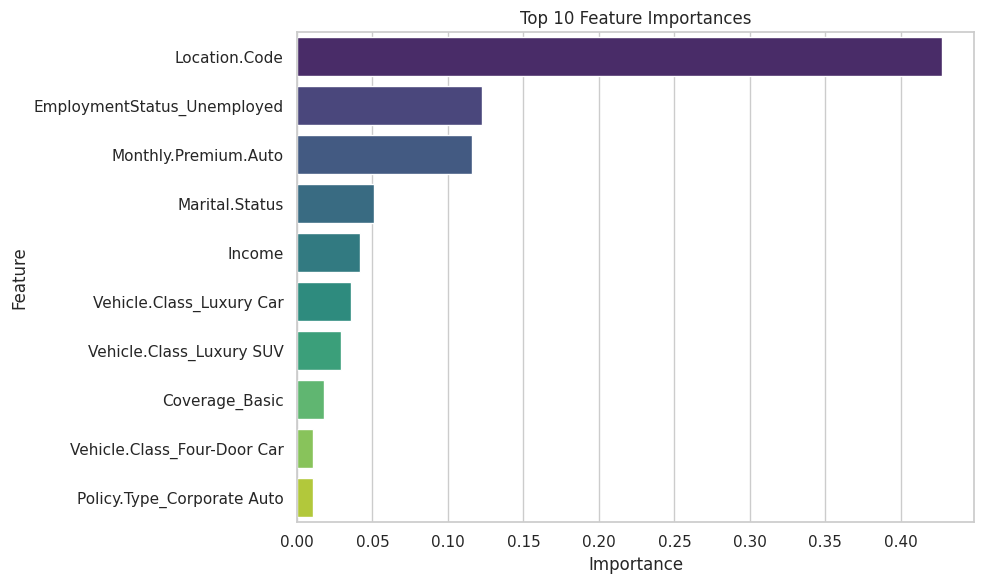

In [212]:

print("\nFeature Importance...")
feature_importances = xgb_model.feature_importances_
feature_importance_df = pd.DataFrame({'Feature': X.columns, 'Importance': feature_importances}).sort_values(
    by='Importance', ascending=False)

# Plot Feature Importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(10), palette='viridis')
plt.title("Top 10 Feature Importances")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

The feature importance plot suggests that the model predictions are mostly driven by location code, suggesting that geographical factors play a critical role in determining insurance claims.

# Part 4: Error Analysis


In [213]:
from sklearn.metrics import r2_score,mean_squared_error,mean_absolute_error,mean_absolute_percentage_error

#### Calculate r2 score

In [214]:
r2_score(y_test,y_pred)

0.8019969246716647

An R² score of 80% indicates strong predictive performance, but the unexplained 20% indicates there is room for improvement, either by performing more feature engineering refining the model, or addressing noise in the data.

#### Calculate Mean Absolute Error


In [215]:
print("Mean absolute error: ",mean_absolute_error(y_pred,y_test))

Mean absolute error:  83.99906403442145


The MAE indicates that the model predictions are off by +- 84 on average

#### Calculate Mean Absolute Percentage Error


In [216]:
print("Mean absolute percentage error: ",mean_absolute_percentage_error(y_pred,y_test))

Mean absolute percentage error:  0.3803920315358539


The Mean Absolute Percentage Error of 38% suggests that the model is typically off by +-38% of the target values which suggests there is a large room for model improvement.

### Predictions vs. True Values

We will now plot the true values against the predicted values. In the regression line, the predicted values are on the function y=x

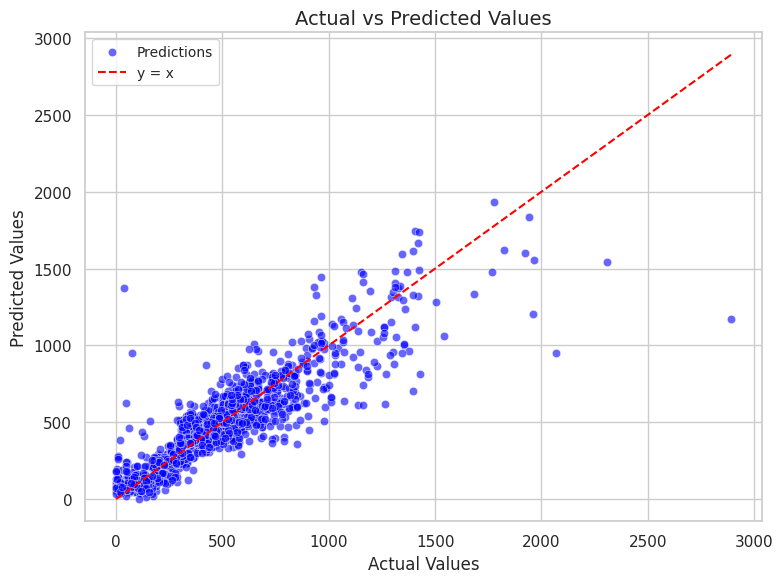

In [217]:
# Set seaborn style
sns.set(style="whitegrid")

# Create a scatter plot using seaborn
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, label='Predictions', color='blue')

# Add the regression line y = x
min_val = min(min(y_test), min(y_pred))
max_val = max(max(y_test), max(y_pred))
plt.plot([min_val, max_val], [min_val, max_val], color='red', linestyle='--', label='y = x')

# Add labels, title, and legend
plt.title("Actual vs Predicted Values", fontsize=14)
plt.xlabel("Actual Values", fontsize=12)
plt.ylabel("Predicted Values", fontsize=12)
plt.legend(fontsize=10)
plt.tight_layout()

# Show the plot
plt.show()


The majority of points are concentrated close to the red line, indicating that the model predictions are generally accurate. Some points deviate significantly from the red line, suggesting significant errors in the model's predictions for those cases. These may represent outliers or areas where the model underperforms.

### Calculate the residuals and the maximum error

In [218]:
# Calculate residuals
residuals = y_test - y_pred

# Calculate the maximum absolute error
max_error = max(abs(residuals))
print(f"Maximum Absolute Error: {max_error}")

Maximum Absolute Error: 1719.9087453828124


The Maximum Absolute Error (MAE) of 1719 represents the largest single prediction error made by the model. This means that, for at least one data point, the difference between the actual value and the predicted value is approximately 1719.

### Plot a histogram of the residuals

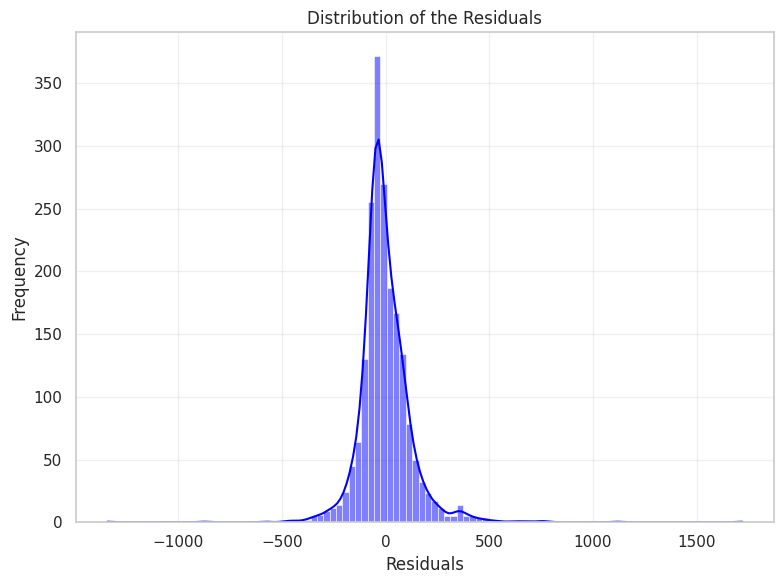

In [219]:
plt.figure(figsize=(8, 6))
sns.histplot(residuals, bins=100, kde=True, color='blue')
plt.title("Distribution of the Residuals")
plt.xlabel("Residuals")
plt.ylabel("Frequency")
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

The residuals are concentrated around zero, suggesting that the model's predictions are close to the actual values for most instances. However, there are some outliers (residuals far from zero) which are instances where the model overestimates or underestimates significantly.

## Plot Absolute Residuals

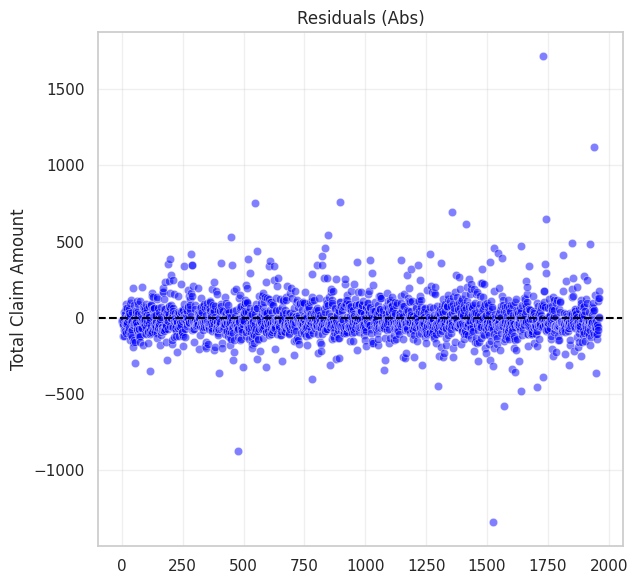

In [220]:
# Calculate residuals
test_set_with_predictions = X_test.copy()

test_set_with_predictions['predicted'] =y_pred
test_set_with_predictions['actual'] =y_test

test_set_with_predictions['residuals'] = test_set_with_predictions['actual'] - test_set_with_predictions['predicted']

# Create subplots
plt.figure(figsize=(12, 6))

# Scatter plot of Absolute Residuals
plt.subplot(1, 2, 1)
sns.scatterplot(x=range(len(test_set_with_predictions['residuals'])), y=test_set_with_predictions['residuals'], alpha=0.5, color='blue')
plt.axhline(y=0, color='black', linestyle='--')  # Black line at zero
plt.title('Residuals (Abs)')
plt.ylabel('Total Claim Amount')
plt.grid(alpha=0.3)


plt.tight_layout()
plt.show()


The residuals appear to be balanced around zero with no obvious trend towards overestimation or underestimation by the model

### Identify Best and Worse Predictions Based on Residuals

In [221]:

# Calculate absolute residuals
test_set_with_predictions['AbsResiduals'] = test_set_with_predictions['residuals'].abs()

# Identify the worst performance (highest absolute errors)
worst_performance = test_set_with_predictions.sort_values(by='AbsResiduals', ascending=False).head(10)

# Identify the best performance (lowest absolute errors)
best_performance = test_set_with_predictions.sort_values(by='AbsResiduals', ascending=True).head(10)

# Display results
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns




In [222]:
print("Worst Predictions:")
worst_performance

Worst Predictions:


,Customer.Lifetime.Value,Gender,Income,Location.Geo,Location.Code,Marital.Status,Monthly.Premium.Auto,Months.Since.Last.Claim,Months.Since.Policy.Inception,Number.of.Open.Complaints,Number.of.Policies,Vehicle.Size,Coverage_Basic,Coverage_Extended,Coverage_Premium,Education_Bachelor,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Disabled,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Policy.Type_Corporate Auto,Policy.Type_Personal Auto,Policy.Type_Special Auto,Policy_Corporate L1,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Policy_Special L1,Policy_Special L2,Policy_Special L3,Renew.Offer.Type_Offer1,Renew.Offer.Type_Offer2,Renew.Offer.Type_Offer3,Renew.Offer.Type_Offer4,Sales.Channel_Agent,Sales.Channel_Branch,Sales.Channel_Call Center,Sales.Channel_Web,Vehicle.Class_Four-Door Car,Vehicle.Class_Luxury Car,Vehicle.Class_Luxury SUV,Vehicle.Class_SUV,Vehicle.Class_Sports Car,Vehicle.Class_Two-Door Car,predicted,actual,residuals,AbsResiduals
1760,8581.278701,1,1005,2402,1,1,239.0,0,72,2.0,1.0,2.0,0,1,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,1173.330933,2893.239678,1719.908745,1719.908745
9643,11701.069850,1,4621,2839,3,1,284.0,11,67,4.0,NaN,2.0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1376.572998,35.768916,-1340.804082,1340.804082
3344,7373.225991,0,2119,1481,1,1,183.0,7,37,0.0,1.0,1.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,949.923218,2069.309854,1119.386636,1119.386636
3894,56675.937680,2,3982,2839,3,3,202.0,34,18,0.0,NaN,2.0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,0,0,951.220581,76.826503,-874.394078,874.394078
4668,6601.611299,1,0,2024,1,2,194.0,22,79,0.0,1.0,2.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,1543.820190,2306.508397,762.688207,762.688207
6383,15483.529860,1,731,258,1,1,196.0,6,28,0.0,7.0,2.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1205.424072,1961.162049,755.737977,755.737977
5970,3833.066768,0,0,1278,1,0,116.0,34,82,NaN,1.0,2.0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,1,0,704.546936,1397.954723,693.407787,693.407787
5035,9339.341599,1,3406,2647,1,1,118.0,26,6,3.0,3.0,3.0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,615.415588,1265.570302,650.154714,650.154714
8706,44468.023030,0,1400,309,1,2,127.0,20,46,1.0,2.0,2.0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,814.770081,1428.972913,614.202832,614.202832
8782,14435.664530,2,4244,2839,3,3,180.0,7,63,0.0,NaN,2.0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,625.084656,45.049185,-580.035471,580.035471


In [223]:
print("\nBest Predictions:")
best_performance


Best Predictions:


,Customer.Lifetime.Value,Gender,Income,Location.Geo,Location.Code,Marital.Status,Monthly.Premium.Auto,Months.Since.Last.Claim,Months.Since.Policy.Inception,Number.of.Open.Complaints,Number.of.Policies,Vehicle.Size,Coverage_Basic,Coverage_Extended,Coverage_Premium,Education_Bachelor,Education_College,Education_Doctor,Education_High School or Below,Education_Master,EmploymentStatus_Disabled,EmploymentStatus_Employed,EmploymentStatus_Medical Leave,EmploymentStatus_Retired,EmploymentStatus_Unemployed,Policy.Type_Corporate Auto,Policy.Type_Personal Auto,Policy.Type_Special Auto,Policy_Corporate L1,Policy_Corporate L2,Policy_Corporate L3,Policy_Personal L1,Policy_Personal L2,Policy_Personal L3,Policy_Special L1,Policy_Special L2,Policy_Special L3,Renew.Offer.Type_Offer1,Renew.Offer.Type_Offer2,Renew.Offer.Type_Offer3,Renew.Offer.Type_Offer4,Sales.Channel_Agent,Sales.Channel_Branch,Sales.Channel_Call Center,Sales.Channel_Web,Vehicle.Class_Four-Door Car,Vehicle.Class_Luxury Car,Vehicle.Class_Luxury SUV,Vehicle.Class_SUV,Vehicle.Class_Sports Car,Vehicle.Class_Two-Door Car,predicted,actual,residuals,AbsResiduals
2436,2619.337376,1,3839,1066,2,0,66.0,7,56,0.0,1.0,2.0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1,225.562805,225.578841,0.016036,0.016036
5464,8085.448545,1,2996,678,2,1,68.0,30,80,0.0,2.0,2.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,1,0,0,0,0,0,263.686554,264.040157,0.353603,0.353603
3979,3544.541005,1,1869,1385,1,2,90.0,25,20,0.0,1.0,2.0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,503.309204,502.873215,-0.435989,0.435989
3833,5626.572446,0,2902,92,1,1,70.0,29,51,0.0,9.0,3.0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,335.562286,336.000000,0.437714,0.437714
1472,7988.258292,0,3781,2728,0,1,99.0,0,21,0.0,3.0,2.0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,99.742439,99.257608,-0.484831,0.484831
212,3372.420457,0,4409,159,0,0,84.0,16,72,0.0,1.0,2.0,0,1,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,0,103.749458,104.280764,0.531306,0.531306
1513,2129.063055,1,0,1303,1,0,61.0,13,81,1.0,1.0,2.0,1,0,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,292.230072,292.800000,0.569928,0.569928
6972,17263.640480,0,4518,925,0,1,61.0,24,2,0.0,2.0,2.0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,0,0,0,0,71.310120,71.942176,0.632056,0.632056
2751,22855.612090,0,390,2076,0,1,65.0,8,32,0.0,2.0,2.0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,55.623074,56.371967,0.748893,0.748893
1965,13334.267630,0,3360,1566,1,1,176.0,8,51,0.0,7.0,2.0,0,0,1,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,0,877.605408,878.400000,0.794592,0.794592
